## City Bikes Trips 2016 Philadelphia

In [61]:
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pyproj import Geod


In [62]:
sns.set_style("whitegrid")

### 1. Loading dataset

In [63]:
df = pd.read_csv("data/Indego_Trips_2016Q2.csv")
df.head()

trip_id  duration     start_time       end_time  start_station_id  \
0  4614547      1620  4/1/2016 0:03  4/1/2016 0:30              3023   
1  4614548       780  4/1/2016 0:06  4/1/2016 0:19              3009   
2  4614549        60  4/1/2016 0:09  4/1/2016 0:10              3063   
3  4614550       360  4/1/2016 0:10  4/1/2016 0:16              3063   
4  4614551       660  4/1/2016 0:11  4/1/2016 0:22              3066   

   start_lat  start_lon  end_station_id   end_lat   end_lon  bike_id  \
0   39.95048  -75.17286            3023  39.95048 -75.17286     3509   
1   39.95576  -75.18982            3066  39.94561 -75.17348     2566   
2   39.94633  -75.16980            3063  39.94633 -75.16980     3281   
3   39.94633  -75.16980            3064  39.93840 -75.17327     3288   
4   39.94561  -75.17348            3047  39.95071 -75.14921     3404   

   plan_duration trip_route_category passholder_type  
0             30          Round Trip        Indego30  
1             30             One Way        Indego30  
2             30          Round Trip        Indego30  
3             30             One Way        Indego30  
4             30             One Way        Indego30

### 2. Data information

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170824 entries, 0 to 170823
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              170824 non-null  int64  
 1   duration             170824 non-null  int64  
 2   start_time           170824 non-null  object 
 3   end_time             170824 non-null  object 
 4   start_station_id     170824 non-null  int64  
 5   start_lat            170824 non-null  float64
 6   start_lon            170824 non-null  float64
 7   end_station_id       170824 non-null  int64  
 8   end_lat              170824 non-null  float64
 9   end_lon              170824 non-null  float64
 10  bike_id              170824 non-null  int64  
 11  plan_duration        170824 non-null  int64  
 12  trip_route_category  170824 non-null  object 
 13  passholder_type      170824 non-null  object 
dtypes: float64(4), int64(6), object(4)
memory usage: 18.2+ MB


### 3. Data preprocessing
We create following rules for the data:
1. Trip needs to last at least 1.5 minutes
2. Length of a trip needs to be at least 150 meters

In [65]:
original_shape = df.shape

#### Dropping rows where duration is less than 90 seconds

In [66]:
df = df.drop(df[df['duration'] < 90].index)
df = df.drop(df[(df['start_lat'] == 0) | (df['start_lon'] == 0) | (df['end_lat'] == 0) | (df['end_lon'] == 0)].index)
new_shape = df.shape

In [67]:
print(f"Number of rows dropped: {original_shape[0] - new_shape[0]}")

Number of rows dropped: 3214


### 4. Number of trips by date, day of week and hour

#### Converting start time to Datetime data type and creating new column: Start Date

In [68]:
df['start_date'] = pd.to_datetime(df['start_time']).dt.date
df['start_date'] = pd.to_datetime(df['start_date'])

In [69]:
ntd = df.groupby("start_date")["start_date"].agg(["count"]).reset_index()
ntd.columns = ["Date", "Trips"]
ntd.head()

Date  Trips
0 2016-04-01   1492
1 2016-04-02   1020
2 2016-04-03    536
3 2016-04-04    907
4 2016-04-05   1046

In [70]:
ntd.tail()

Date  Trips
86 2016-06-26   2325
87 2016-06-27   2186
88 2016-06-28   2296
89 2016-06-29   2932
90 2016-06-30   2733

#### Average trips per day

In [71]:
atpd = round(ntd["Trips"].mean())
print(f"Average trips per day: {atpd} trips")

Average trips per day: 1842 trips


#### 4.1. Number of trips per date

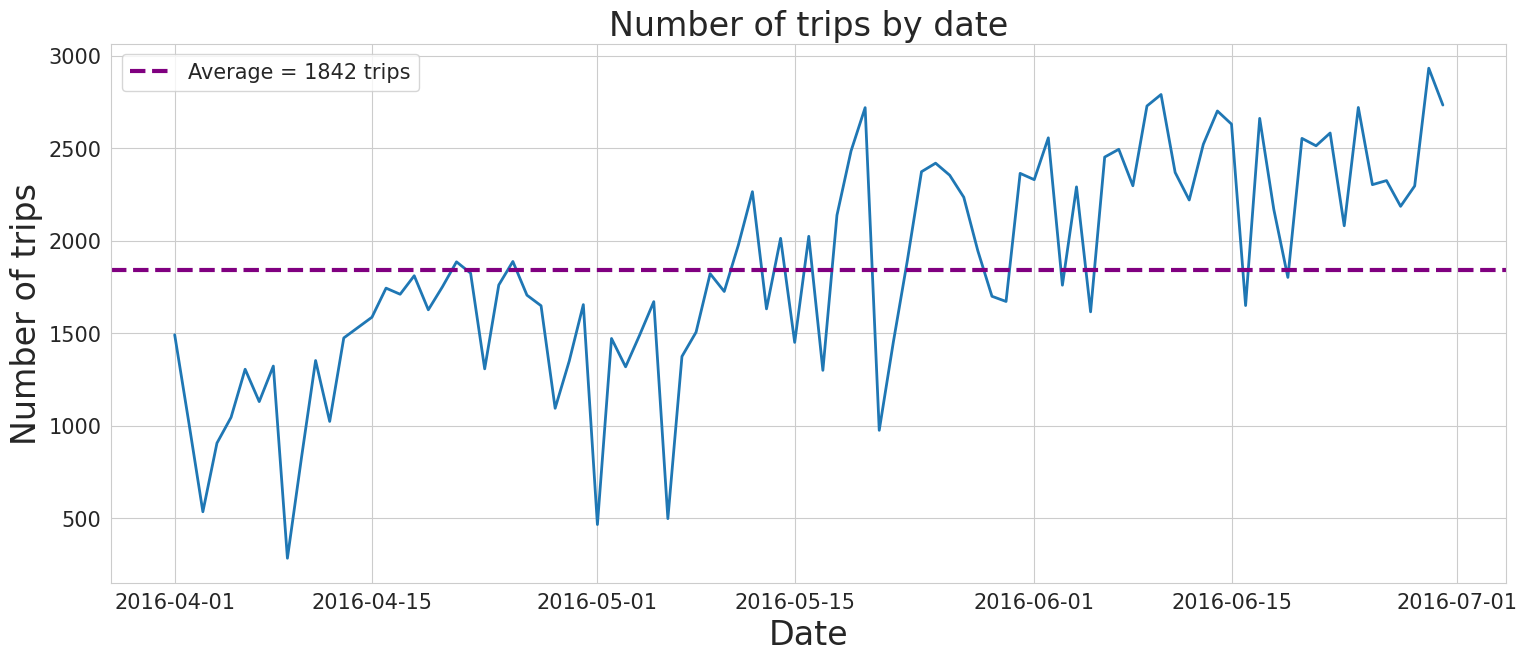

In [72]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trips", data=ntd, linewidth=2)
plot.axhline(atpd, linestyle="--", color="purple", label=f"Average = {atpd} trips", linewidth=3)
plt.title("Number of trips by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.2. Number of trips by day of week

#### Extracting day of week from Start Date column

In [73]:
df["day_of_week"] = df["start_date"].dt.day_name()

In [74]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tdw = df.groupby("day_of_week")["day_of_week"].agg(["count"]).reindex(cats).reset_index()
tdw.columns = ["Day Of Week", "Trips"]
tdw

Day Of Week  Trips
0      Monday  24556
1     Tuesday  24489
2   Wednesday  26976
3    Thursday  26166
4      Friday  24593
5    Saturday  21454
6      Sunday  19376

#### Average trips per day of week

In [75]:
atdw = round(tdw["Trips"].mean())
print(f"Average trips per day of week: {atdw}")

Average trips per day of week: 23944


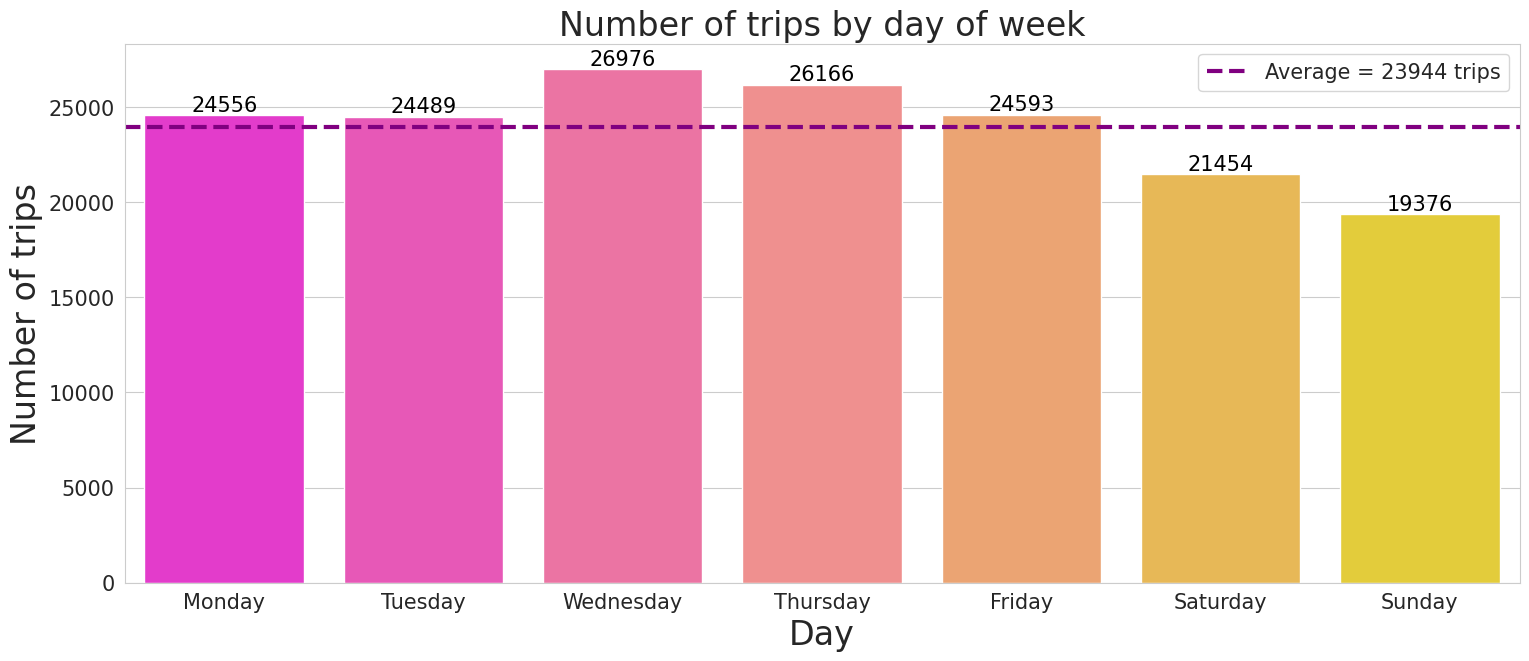

In [76]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day Of Week", y="Trips", data=tdw, palette="spring")
for p in plot.patches:
    plot.annotate('{:.0f}'.format(p.get_height()),
                  (p.get_x() + 0.4, p.get_height()),
                  ha='center', va='bottom', color='black', size=15)
plot.axhline(atdw, linestyle="--", color="purple", label=f"Average = {atdw} trips", linewidth=3)
plt.title("Number of trips by day of week", size=24)
plt.xlabel("Day", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.3. Distribution of trips over hours of the day

In [77]:
df["hour"] = pd.to_datetime(df["start_time"]).dt.hour

In [78]:
thd = df["hour"].value_counts().to_frame().reset_index()
thd.columns = ["Hour", "Trips"]
thd

Hour  Trips
0     17  18853
1     18  14216
2      8  13045
3     16  12673
4     19  11194
5     15  10214
6     14   9339
7     13   8856
8      9   8640
9     12   8626
10    20   8245
11     7   7502
12    11   7349
13    10   6503
14    21   5794
15    22   4365
16     6   3677
17    23   2889
18     0   1920
19     5   1130
20     1   1064
21     2    835
22     3    406
23     4    275

#### Average trips per hour

In [79]:
athd = round(thd["Trips"].mean())
print(f"Average trips per hour: {athd}")

Average trips per hour: 6984


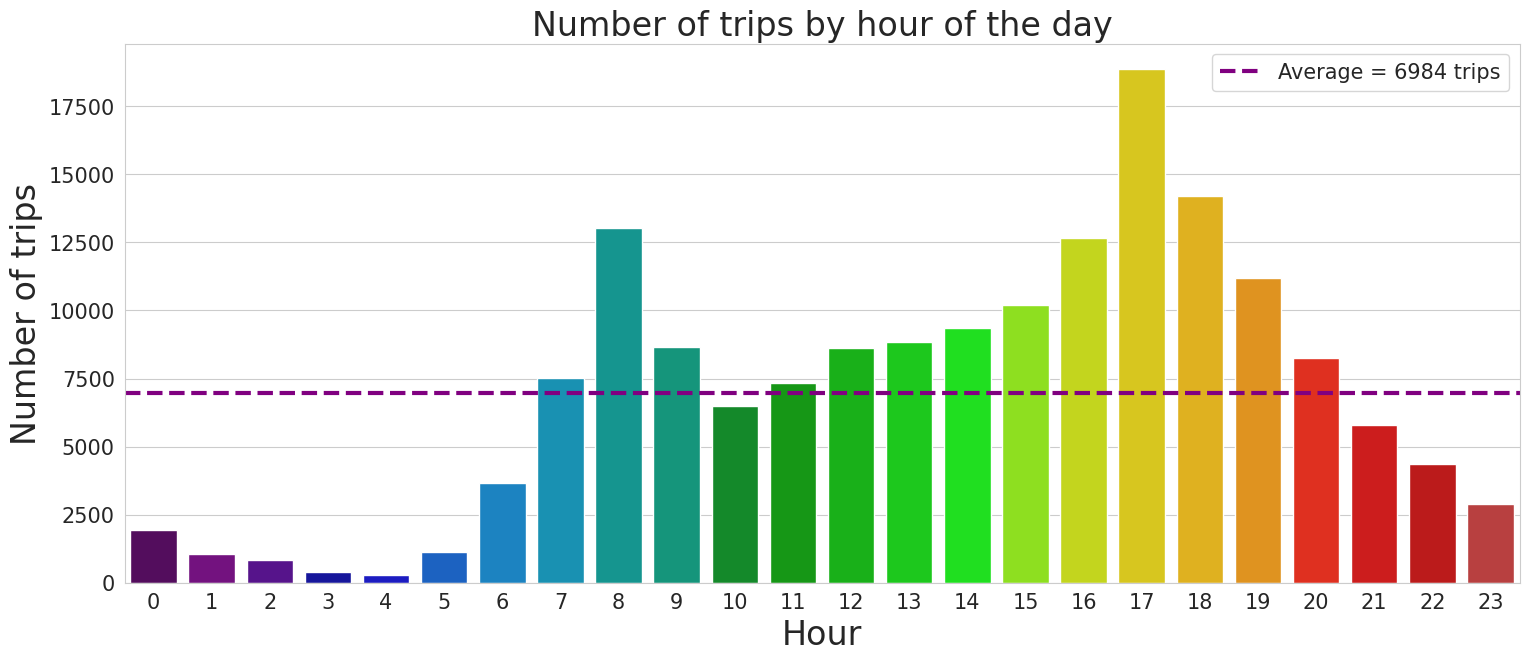

In [80]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Trips", data=thd, palette="nipy_spectral")
plot.axhline(athd, linestyle="--", color="purple", label=f"Average = {athd} trips", linewidth=3)
plt.title("Number of trips by hour of the day", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.4. Number of trips by start area

#### Adding new columns with information about the neighbourhood that given location is in and coordinates describing the center of this neighbourhood

In [81]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [82]:
from tqdm import tqdm
road_map = {}
area_coords = {}
for row in tqdm(df.itertuples()):
    index = row.Index
    start_lat, end_lat= row.start_lat, row.end_lat
    start_lon, end_lon= row.start_lon, row.end_lon
    if start_lat not in road_map:
        start_loc = geolocator.reverse(f"{start_lat},{start_lon}")
        if start_loc and 'road' in start_loc.raw['address']:
            start_loc = start_loc.raw
            start_neigh = start_loc['address']['road']
            road_map[start_lat] = start_neigh
            area_center = geolocator.geocode(f"Philadelphia {start_neigh}")
            if area_center:
                area_coords[start_neigh] = {'lat': area_center.latitude, 'lon': area_center.longitude}
    if end_lat not in road_map:
        end_loc = geolocator.reverse(f"{end_lat},{end_lon}")
        if end_loc and 'road' in end_loc.raw['address']:
            end_loc = end_loc.raw
            end_neigh = end_loc['address']['road']
            road_map[end_lat] = end_neigh
            area_center = geolocator.geocode(f"Philadelphia {end_neigh}")
            if area_center:
                area_coords[end_neigh] = {'lat': area_center.latitude, 'lon': area_center.longitude}

167610it [01:45, 1594.80it/s] 


In [83]:
for row in tqdm(df.itertuples()):
    index = row.Index
    start_lat, end_lat = row.start_lat, row.end_lat
    if start_lat in road_map:
        start_neigh = road_map[start_lat]
        df.at[index, "Start Area Name"] = start_neigh
        if start_neigh in area_coords:
            df.at[index, "Start Centroid Latitude"] = area_coords[start_neigh]['lat']
            df.at[index, "Start Centroid Longitude"] = area_coords[start_neigh]['lon']
        
    if end_lat in road_map:
        end_neigh = road_map[end_lat]
        df.at[index, "End Area Name"] = end_neigh
        if end_neigh in area_coords:
            df.at[index, "End Centroid Latitude"] = area_coords[end_neigh]['lat']
            df.at[index, "End Centroid Longitude"] = area_coords[end_neigh]['lon']

167610it [00:05, 31171.85it/s]


In [84]:
ntbsa = df["Start Area Name"].value_counts().to_frame().reset_index()
ntbsa.columns = ["Start Area Name", "Trips"]
ntbsa

Start Area Name  Trips
0          Market Street  15624
1          Walnut Street   7991
2     South Broad Street   6948
3     North Broad Street   6297
4       Fairmount Avenue   6152
..                   ...    ...
67     North 39th Street    313
68          Beach Street    245
69  33rd Street Sidepath    236
70    West Master Street    163
71     North 34th Street    146

[72 rows x 2 columns]

#### 4.5. Number of trips by destination area

In [85]:
ntbea = df["End Area Name"].value_counts().to_frame().reset_index()
ntbea.columns = ["End Area Name", "Trips"]
ntbea

End Area Name  Trips
0          Market Street  15744
1          Walnut Street   8318
2     South Broad Street   6795
3     North Broad Street   5843
4      North 18th Street   5775
..                   ...    ...
68     North 39th Street    262
69  33rd Street Sidepath    215
70    West Master Street    149
71     North 34th Street    103
72      North 5th Street      1

[73 rows x 2 columns]

### 5. Average trip duration

In [86]:
df["trip_duration_in_min"] = df["duration"]/60
avd = round(df["trip_duration_in_min"].mean(), 2)
print(f"Average duration of trip: {avd} minutes")

Average duration of trip: 23.91 minutes


#### 6.1. Average trip duration by date

In [87]:
atdbd = df.groupby(["start_date"]).agg({"trip_duration_in_min": "mean"}).reset_index()
atdbd["trip_duration_in_min"] = round(atdbd["trip_duration_in_min"],2)
atdbd.columns = ["Date", "Trip Duration"]
atdbd.head()

Date  Trip Duration
0 2016-04-01          22.09
1 2016-04-02          28.32
2 2016-04-03          19.54
3 2016-04-04          20.19
4 2016-04-05          18.65

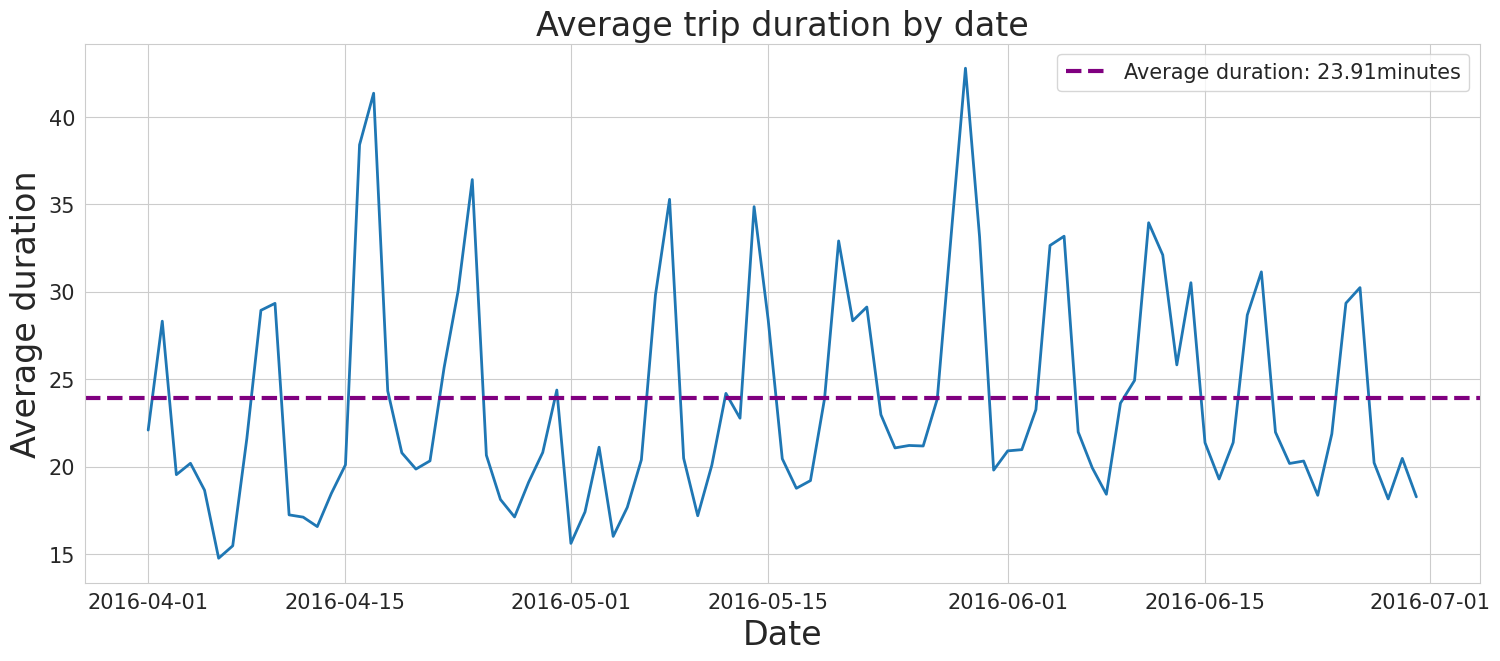

In [88]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trip Duration", data=atdbd, linewidth=2)
plot.axhline(avd, linestyle="--", color="purple", label=f"Average duration: {avd}minutes", linewidth=3)
plt.title("Average trip duration by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Average duration", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.2. Average trip duration by day of week

In [89]:
adbd = df.groupby(["day_of_week"]).agg({"trip_duration_in_min": "mean"}).reset_index()
adbd.columns = ["Day Of Week", "Average Trip Duration"]
adbd["Average Trip Duration"] = round(adbd["Average Trip Duration"],2)
adbd

Day Of Week  Average Trip Duration
0      Friday                  23.80
1      Monday                  22.29
2    Saturday                  31.35
3      Sunday                  32.91
4    Thursday                  20.51
5     Tuesday                  20.62
6   Wednesday                  19.36

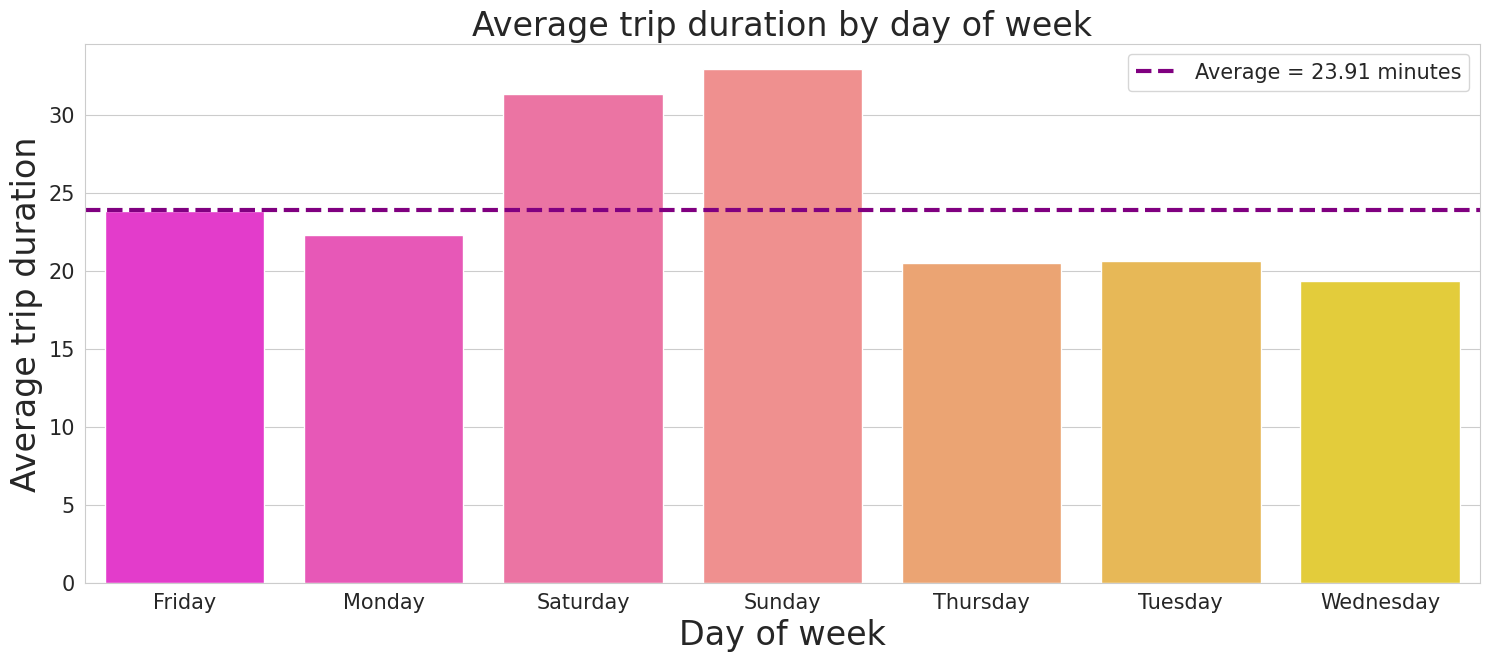

In [90]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day Of Week", y="Average Trip Duration", data=adbd, palette="spring")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd} minutes", linewidth=3)
plt.title("Average trip duration by day of week", size=24)
plt.xlabel("Day of week", size=24)
plt.ylabel("Average trip duration", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.3. Average trip duration by hour of the day

In [91]:
adbh = df.groupby(["hour"]).agg({"trip_duration_in_min": "mean"}).reset_index()
adbh.columns = ["Hour", "Average Trip Duration"]
adbh["Average Trip Duration"] = round(adbh["Average Trip Duration"],2)
adbh

Hour  Average Trip Duration
0      0                  40.09
1      1                  43.34
2      2                  46.61
3      3                  44.09
4      4                  24.14
5      5                  16.32
6      6                  15.16
7      7                  14.97
8      8                  15.13
9      9                  19.83
10    10                  22.90
11    11                  29.07
12    12                  30.35
13    13                  28.13
14    14                  29.06
15    15                  28.13
16    16                  23.15
17    17                  21.33
18    18                  21.33
19    19                  24.70
20    20                  25.46
21    21                  24.44
22    22                  28.35
23    23                  28.56

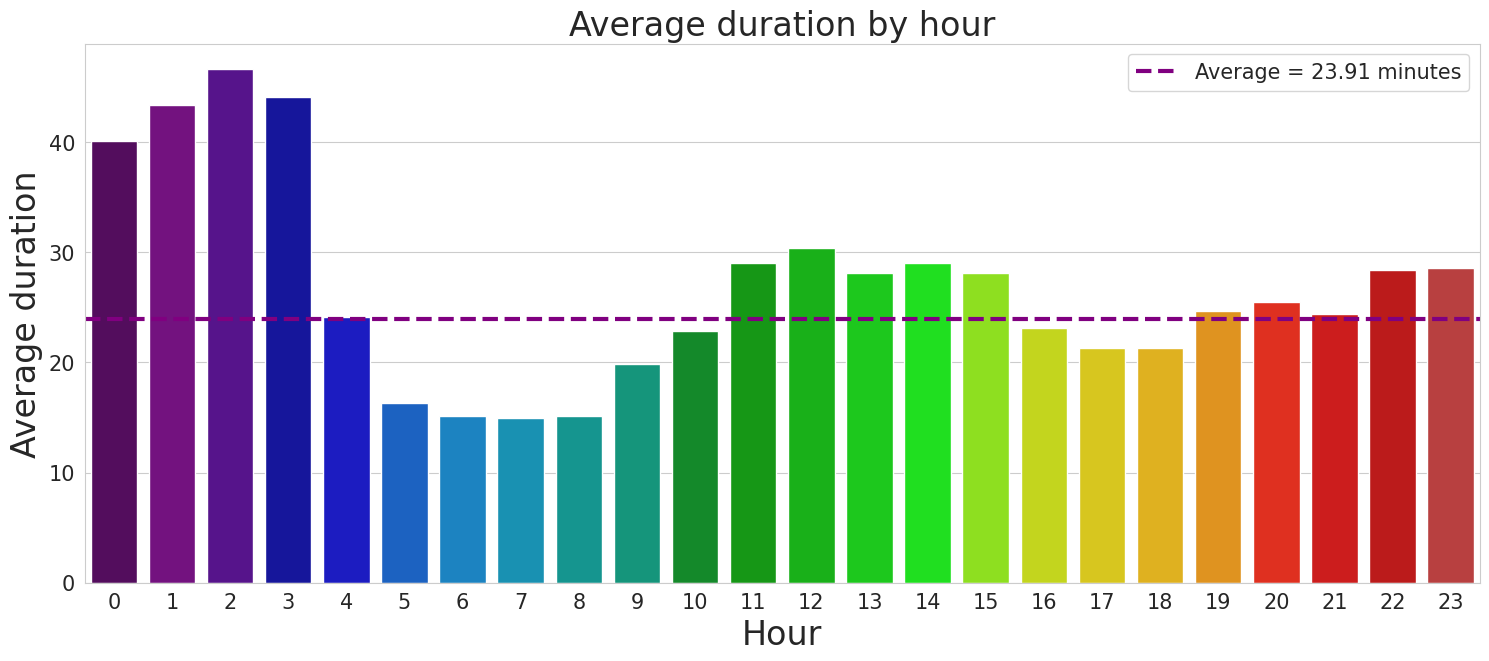

In [92]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Average Trip Duration", data=adbh, palette="nipy_spectral")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd} minutes", linewidth=3)
plt.title("Average duration by hour", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Average duration", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 7. Trips statistics for first and last 15 days

#### First 15 days

In [93]:
ftd = df[(df["start_date"] >= "2016-04-01") & (df["start_date"] <= "2016-04-14")]
ftd["Time Period"] = "First 15 Days"

#### Last 15 days

In [94]:
ltd = df[(df["start_date"] >= "2016-06-17") & (df["start_date"] <= "2016-06-30")]
ltd["Time Period"] = "Last 15 Days"

In [95]:
fltd = pd.concat([ftd, ltd])

#### 7.1. Statistics by time period

In [96]:
fl_15 = fltd.groupby("Time Period").agg({"Time Period": "count",
                                         "trip_duration_in_min": "mean"})
fl_15.columns = ["Trips", "Trips Duration"]
fl_15["Trips Duration"] = round(fl_15["Trips Duration"], 2)
fl_15 = fl_15.reset_index()
fl_15

Time Period  Trips  Trips Duration
0  First 15 Days  15258           19.77
1   Last 15 Days  33857           22.62

#### 7.2. Statistics by day of week and time period

In [97]:
fltdg = fltd.groupby(["day_of_week", "Time Period"]).agg({"Time Period": "count",
                                                          "trip_duration_in_min": "mean"})
fltdg["trip_duration_in_min"] = round(fltdg["trip_duration_in_min"],2)
fltdg.columns = ["Trips", "Trips Duration"]
fltdg = fltdg.reset_index()
fltdg

day_of_week    Time Period  Trips  Trips Duration
0       Friday  First 15 Days   2815           21.86
1       Friday   Last 15 Days   5381           21.63
2       Monday  First 15 Days   2260           18.42
3       Monday   Last 15 Days   4739           21.16
4     Saturday  First 15 Days   1305           28.46
5     Saturday   Last 15 Days   4473           29.02
6       Sunday  First 15 Days   1365           25.49
7       Sunday   Last 15 Days   4127           30.63
8     Thursday  First 15 Days   2662           17.19
9     Thursday   Last 15 Days   4814           18.31
10     Tuesday  First 15 Days   2070           17.89
11     Tuesday   Last 15 Days   4809           19.21
12   Wednesday  First 15 Days   2781           15.72
13   Wednesday   Last 15 Days   5514           20.40

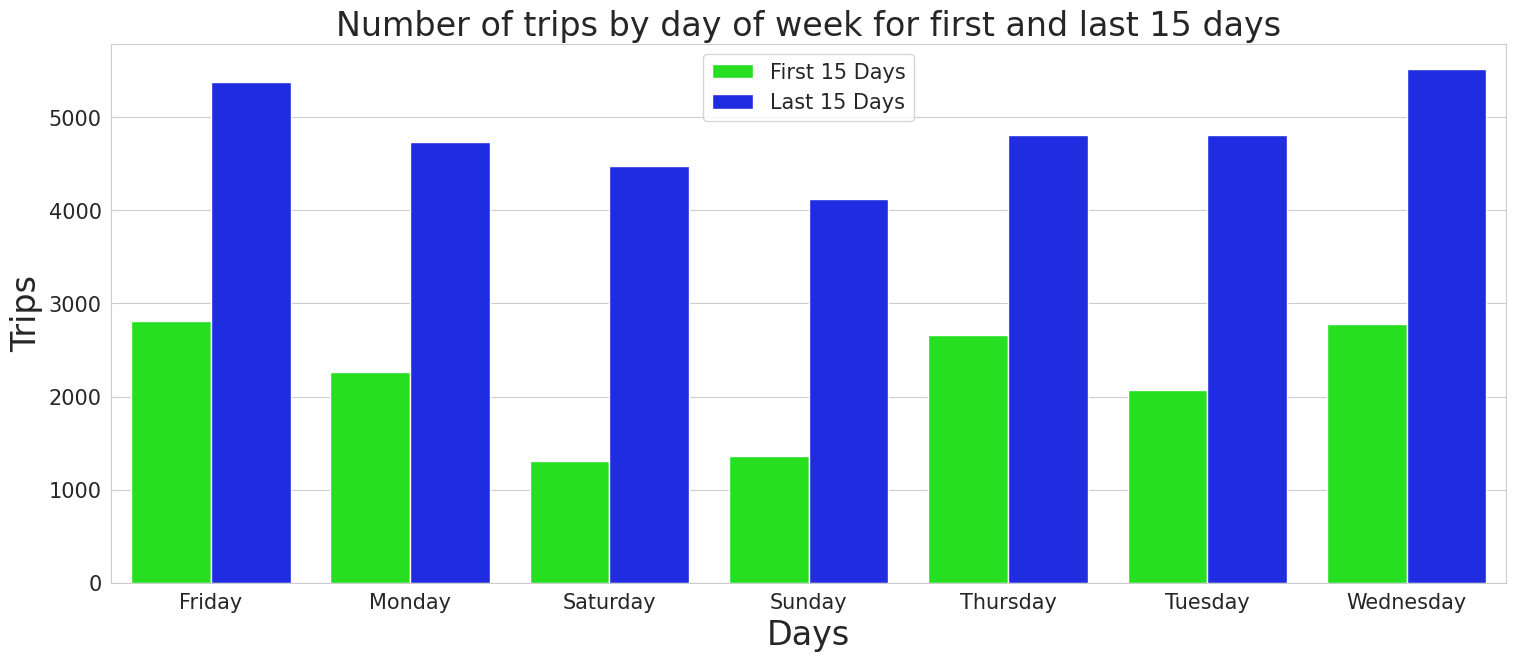

In [98]:
plt.figure(figsize=(18, 7))
sns.barplot(x="day_of_week", y="Trips", hue="Time Period", data=fltdg, palette="hsv")
plt.title("Number of trips by day of week for first and last 15 days", size=24)
plt.xlabel("Days", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 7.3. Statistics by hour and time period

In [99]:
fltdh = fltd.groupby(["hour", "Time Period"])["Time Period"].agg(["count"]).reset_index()
fltdh.columns = ["Hour", "Time Period", "Trips"]
fltdh

Hour    Time Period  Trips
0      0  First 15 Days    153
1      0   Last 15 Days    444
2      1  First 15 Days     77
3      1   Last 15 Days    253
4      2  First 15 Days     65
5      2   Last 15 Days    184
6      3  First 15 Days     26
7      3   Last 15 Days     74
8      4  First 15 Days     24
9      4   Last 15 Days     82
10     5  First 15 Days     87
11     5   Last 15 Days    252
12     6  First 15 Days    328
13     6   Last 15 Days    800
14     7  First 15 Days    777
15     7   Last 15 Days   1529
16     8  First 15 Days   1407
17     8   Last 15 Days   2663
18     9  First 15 Days    804
19     9   Last 15 Days   1732
20    10  First 15 Days    524
21    10   Last 15 Days   1284
22    11  First 15 Days    602
23    11   Last 15 Days   1464
24    12  First 15 Days    716
25    12   Last 15 Days   1691
26    13  First 15 Days    741
27    13   Last 15 Days   1690
28    14  First 15 Days    847
29    14   Last 15 Days   1724
30    15  First 15 Days    913
31    15   Last 15 Days   1983
32    16  First 15 Days   1265
33    16   Last 15 Days   2439
34    17  First 15 Days   1865
35    17   Last 15 Days   3658
36    18  First 15 Days   1383
37    18   Last 15 Days   3053
38    19  First 15 Days    946
39    19   Last 15 Days   2287
40    20  First 15 Days    669
41    20   Last 15 Days   1809
42    21  First 15 Days    467
43    21   Last 15 Days   1194
44    22  First 15 Days    346
45    22   Last 15 Days    926
46    23  First 15 Days    226
47    23   Last 15 Days    642

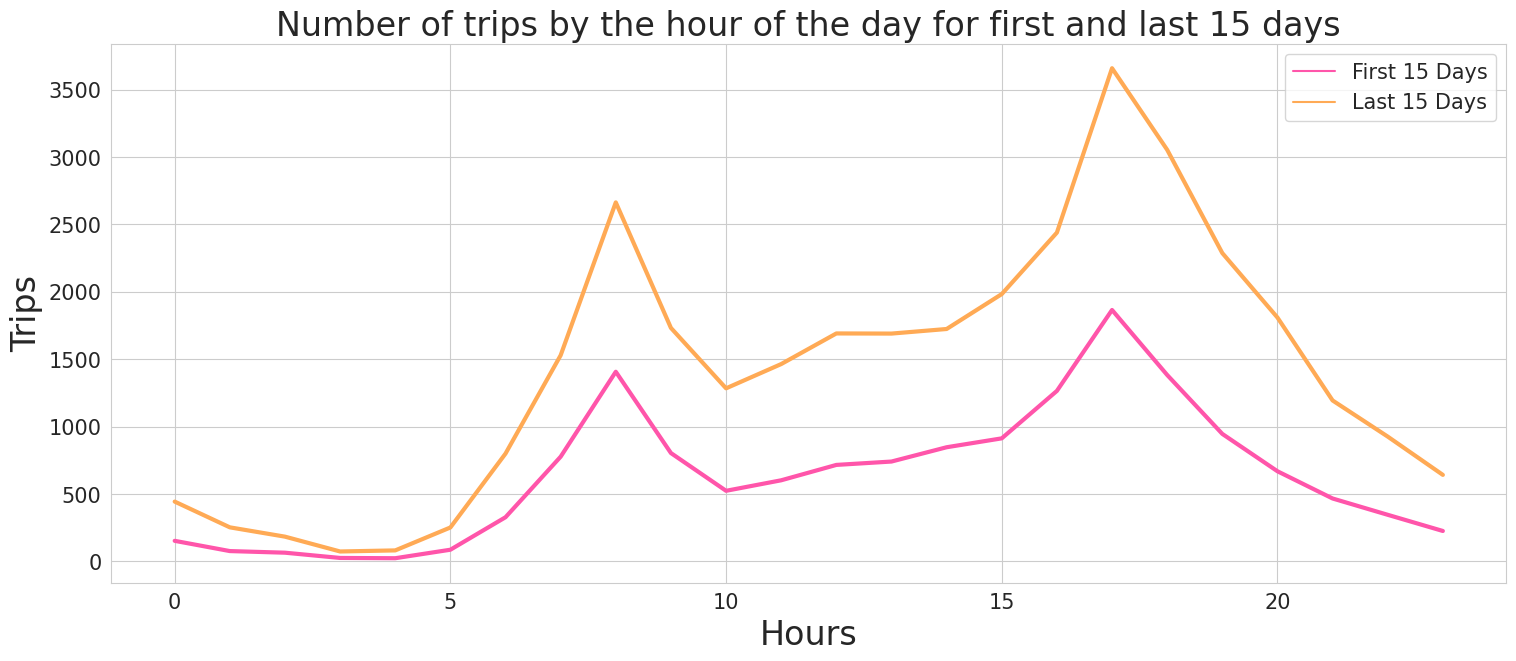

In [100]:
plt.figure(figsize=(18, 7))
sns.lineplot(x="Hour", y="Trips", hue="Time Period", data=fltdh, palette="spring", linewidth=3)
plt.title("Number of trips by the hour of the day for first and last 15 days", size=24)
plt.xlabel("Hours", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 8. Starts analysis


#### 8.1. Starts count on map

In [101]:
df_location_start = df[['Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
df_location_start, counts_start = np.unique(df_location_start, return_counts=True, axis=0)
df_location_start = np.append(df_location_start, counts_start.reshape((df_location_start.shape[0], -1)), axis=1)

In [102]:
def draw_starts_number_map(data):
    location_start_map = folium.Map(location=[39.9539, -75.16902], zoom_start=13)
    for row in data:
        lat = row[0]
        long = row[1]
        count = row[2]
        radius = count / 3500
        color = "#FF4500"
        popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    Starts numer : {}<br>"""
        popup_text = popup_text.format(lat, long, count)
        folium.CircleMarker(location=(lat, long), fill=True, radius=radius, popup=popup_text, color=color).add_to(
            location_start_map)
    return location_start_map


draw_starts_number_map(df_location_start)

#### 8.1. Put back location

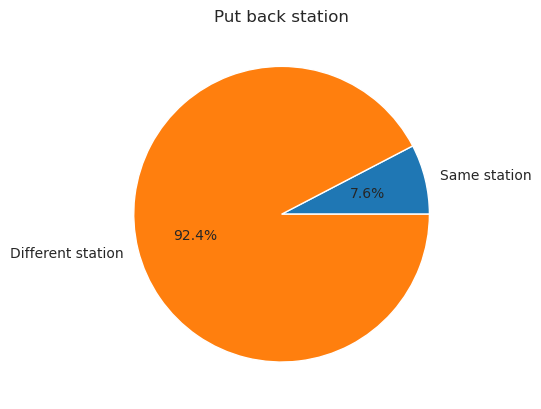

In [103]:
areas = df[["start_station_id", 'end_station_id']].value_counts().to_frame().reset_index()
areas.columns = ["start_station_id", 'end_station_id', "count"]
same_district = areas[(areas["start_station_id"] == areas['end_station_id'])].reset_index()
different_district = areas[(areas["start_station_id"] != areas['end_station_id'])].reset_index()

fig, ax = plt.subplots()
ax.pie([same_district["count"].sum(), different_district["count"].sum()],
       labels=["Same station", "Different station"], autopct='%1.1f%%')
plt.title("Put back station")
plt.show()

### 9. Traffic flow analysis


In [104]:
areas = df[["Start Area Name", 'End Area Name']].dropna()
unique_areas = np.unique(areas)
area_count = unique_areas.shape[0]
areas_map = {}
for i, area_no in enumerate(unique_areas):
    areas_map[area_no] = i

different_district = areas[
    (areas["Start Area Name"] != areas['End Area Name'])]  #.reset_index()

transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)

for i, trip in enumerate(different_district.iloc):
    t0 = np.str(trip[0])
    t1 = np.str(trip[1])
    if t0 > t1:
        transfer_arr[areas_map[t0], areas_map[t1]] += 1
    else:
        transfer_arr[areas_map[t0], areas_map[t1]] -= 1

In [105]:
transfer_arr_norm = transfer_arr / np.linalg.norm(transfer_arr)
print(transfer_arr_norm.shape)

(73, 73)


In [106]:
area_geo_start_position = df[['Start Area Name', 'Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
area_geo_start_position = area_geo_start_position.drop_duplicates(subset="Start Area Name")
area_geo_start_position = area_geo_start_position.sort_values(by=['Start Area Name'])
area_geo_start_position = np.array(area_geo_start_position)
area_geo_end_position = df[['End Area Name', 'End Centroid Latitude', 'End Centroid Longitude']].dropna()
area_geo_end_position = area_geo_end_position.drop_duplicates(subset="End Area Name")
area_geo_end_position = area_geo_end_position.sort_values(by=['End Area Name'])
area_geo_end_position = np.array(area_geo_end_position)
area_geo_position = np.concatenate((area_geo_start_position,area_geo_end_position),0)

In [107]:
list_colors = [
    "#00FF00",
    "#12FF00",
    "#24FF00",
    "#35FF00",
    "#47FF00",
    "#58FF00",
    "#6AFF00",
    "#7CFF00",
    "#8DFF00",
    "#9FFF00",
    "#B0FF00",
    "#C2FF00",
    "#D4FF00",
    "#E5FF00",
    "#F7FF00",
    "#FFF600",
    "#FFE400",
    "#FFD300",
    "#FFC100",
    "#FFAF00",
    "#FF9E00",
    "#FF8C00",
    "#FF7B00",
    "#FF6900",
    "#FF5700",
    "#FF4600",
    "#FF3400",
    "#FF2300",
    "#FF1100",
    "#FF0000",
]
color_dict = {i: list_colors[i] for i in range(len(list_colors))}

In [108]:
def draw_flow_map(treshold=1):
    max_count = np.max(transfer_arr)
    print(max_count)
    location_start_map = folium.Map(location=[39.9539, -75.16902], zoom_start=12)
    for y in range(transfer_arr.shape[0]):
        for x in range(transfer_arr.shape[1]):
            if x > y and np.abs(transfer_arr[x, y]) > max_count * treshold:
                start_lat = area_geo_position[x, 1]
                start_long = area_geo_position[x, 2]
                end_lat = area_geo_position[y, 1]
                end_long = area_geo_position[y, 2]

                coordinates = [
                    [start_lat, start_long],
                    [end_lat, end_long]
                ]

                color = np.floor(np.log(np.abs(transfer_arr[x, y])) * (30 / np.ceil(np.log(max_count))))
                line = folium.PolyLine(locations=coordinates, weight=color / 2, color=color_dict[color])
                location_start_map.add_child(line)

                geodesic = Geod(ellps='WGS84')
                if transfer_arr[x, y] > 0:
                    rotation = geodesic.inv(start_long, start_lat, end_long, end_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(location=(
                    (end_lat - start_lat) * 0.95 + start_lat, (end_long - start_long) * 0.95 + start_long),
                                                             color=color_dict[color], number_of_sides=3,
                                                             radius=color * 0.75, rotation=rotation)
                else:
                    rotation = geodesic.inv(end_long, end_lat, start_long, start_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(
                        location=((start_lat - end_lat) * 0.95 + end_lat, (start_long - end_long) * 0.95 + end_long),
                        color=color_dict[color], number_of_sides=3, radius=color * 0.75, rotation=rotation)
                location_start_map.add_child(arrow_head)
    return location_start_map

In [109]:
draw_flow_map(0.01)

870


#### 9.1. Traffic flow - morning

In [110]:
def parseDateTime(dateTime: str, fromTime: int, toTime: int):
    result = []
    for dT in dateTime:
        tmp = dT.split()[1:3]
        hour = int(tmp[0].split(':')[0])
        if fromTime <= hour <= toTime:
            result.append(True)
        else:
            result.append(False)
    return np.array(result)

In [111]:
areas = df[["start_time", "Start Area Name", "End Area Name"]].dropna()
district_filter = np.array(areas["Start Area Name"] != areas['End Area Name'])
hour_filter = parseDateTime(areas['start_time'], 6, 10)
sum_filter = []
for i in range(len(district_filter)):
    if district_filter[i] == True and hour_filter[i] == True:
        sum_filter.append(True)
    else:
        sum_filter.append(False)
hour_district = np.array(areas[sum_filter])
transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)

for i, trip in enumerate(hour_district):
    t0 = np.str(trip[1])
    t1 = np.str(trip[2])
    if t0 > t1:
        transfer_arr[areas_map[t0], areas_map[t1]] += 1
    else:
        transfer_arr[areas_map[t0], areas_map[t1]] -= 1

In [112]:
draw_flow_map(0.01)

248


#### 9.2. Traffic flow - afternoon


In [113]:
draw_flow_map(0.01)

248


#### 9.3 Traffic flow per hour


In [114]:
start_area = df[['Start Area Name', 'hour']].groupby(
    ["Start Area Name", "hour"]).value_counts().reset_index()
start_area.columns = ["Area", "Hour", "Trips"]
start_area["Type"] = ["Start"] * len(start_area)
end_area = df[['End Area Name', 'hour']].groupby(
    ["End Area Name", "hour"]).value_counts().reset_index()
end_area.columns = ["Area", "Hour", "Trips"]
end_area["Type"] = ["End"] * len(end_area)
area_hour_start_end = pd.concat([start_area, end_area])
area_hour_start_end

Area  Hour  Trips   Type
0     33rd Street Sidepath     0      2  Start
1     33rd Street Sidepath     1      1  Start
2     33rd Street Sidepath     7      7  Start
3     33rd Street Sidepath     8     12  Start
4     33rd Street Sidepath     9     20  Start
...                    ...   ...    ...    ...
1661    West Master Street    19     18    End
1662    West Master Street    20     20    End
1663    West Master Street    21     20    End
1664    West Master Street    22      5    End
1665    West Master Street    23      5    End

[3327 rows x 4 columns]

In [115]:
def plot_area_hour_start_end(district):
    plt.figure(figsize=(18, 7))
    sns.barplot(x="Hour", y="Trips", hue="Type", data=area_hour_start_end[area_hour_start_end['Area'] == district],
                palette="hsv")
    plt.title(f'Number of starts and ends by hour in {district}', size=24)
    plt.xlabel("Hours", size=24)
    plt.ylabel("Trips", size=24)
    plt.legend(prop={'size': 15})
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()

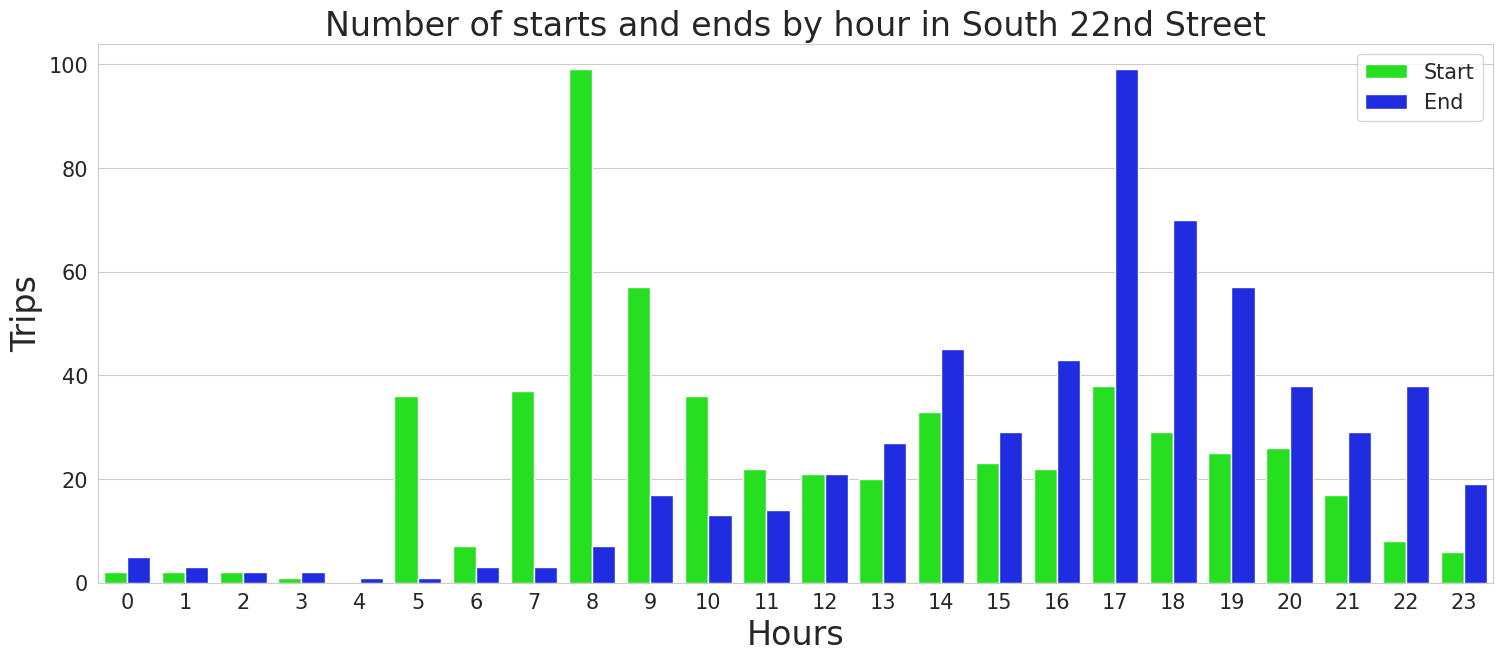

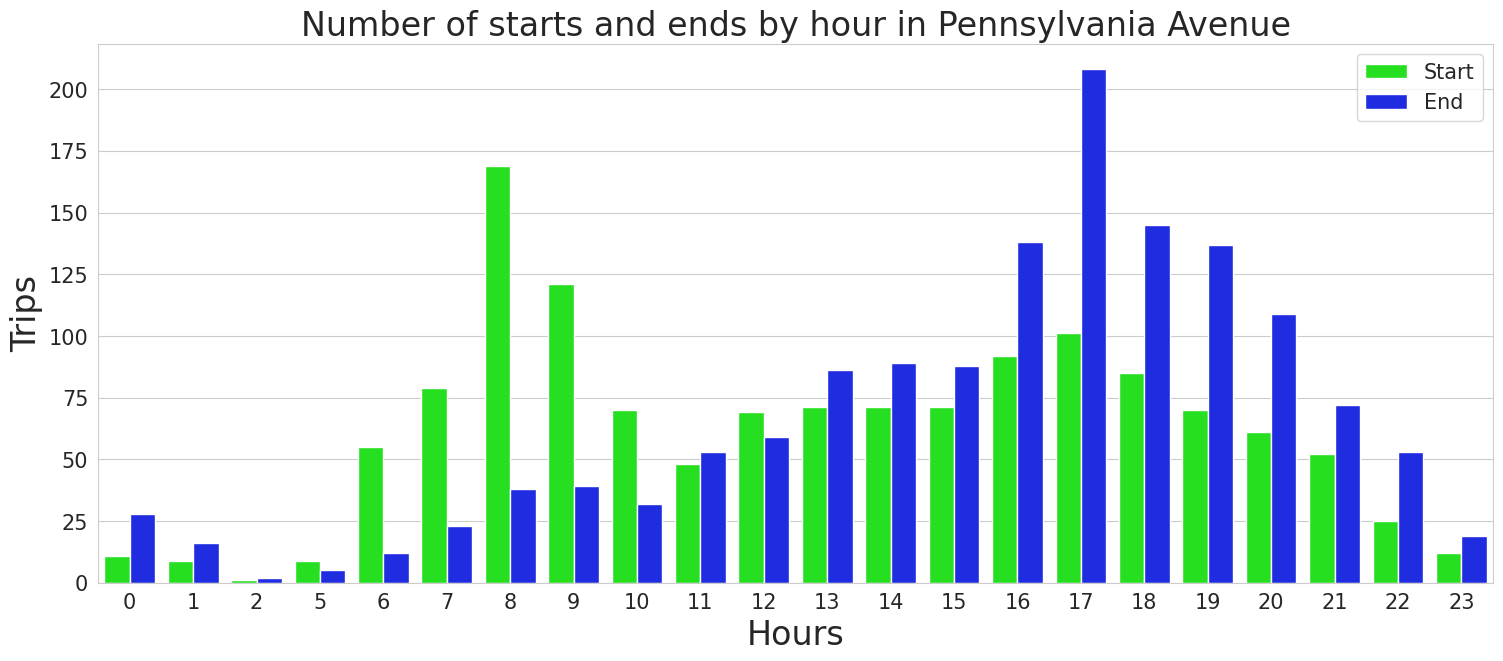

In [116]:
districts = ["South 22nd Street", "Pennsylvania Avenue"]

for district in districts:
    plot_area_hour_start_end(district)

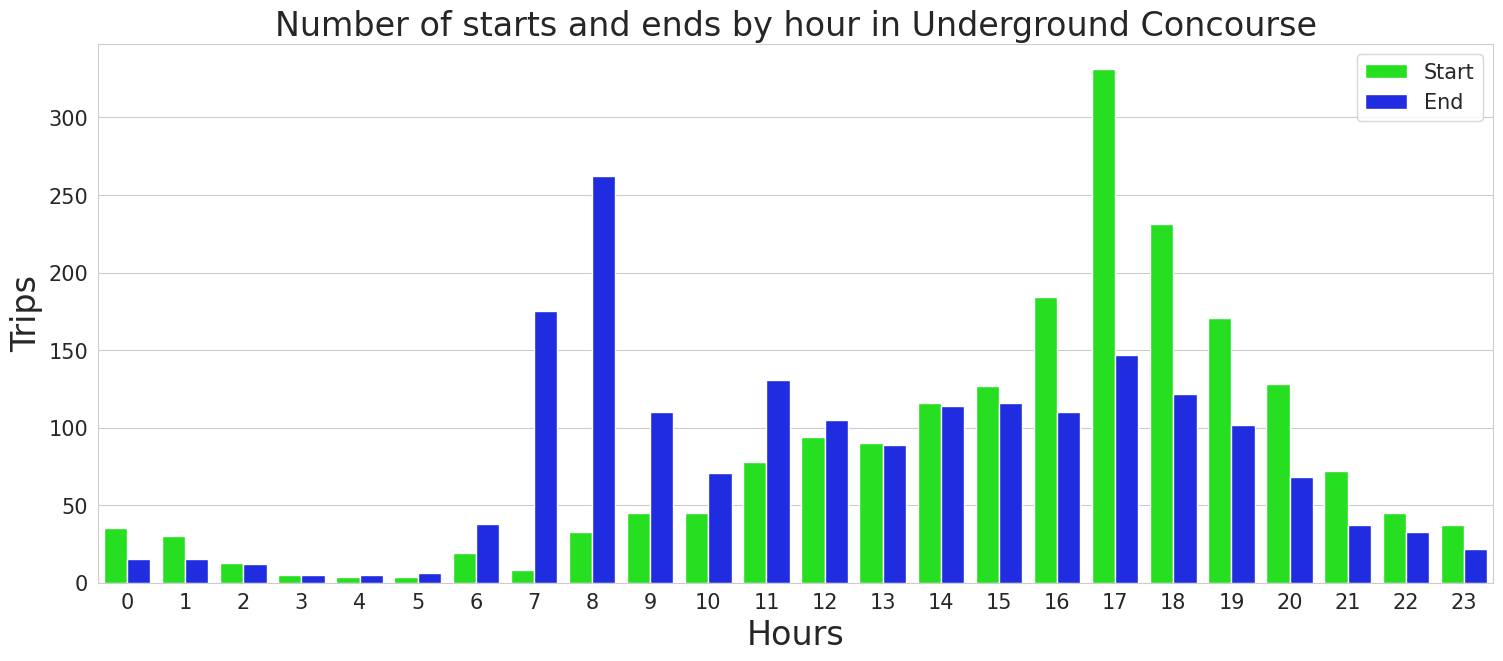

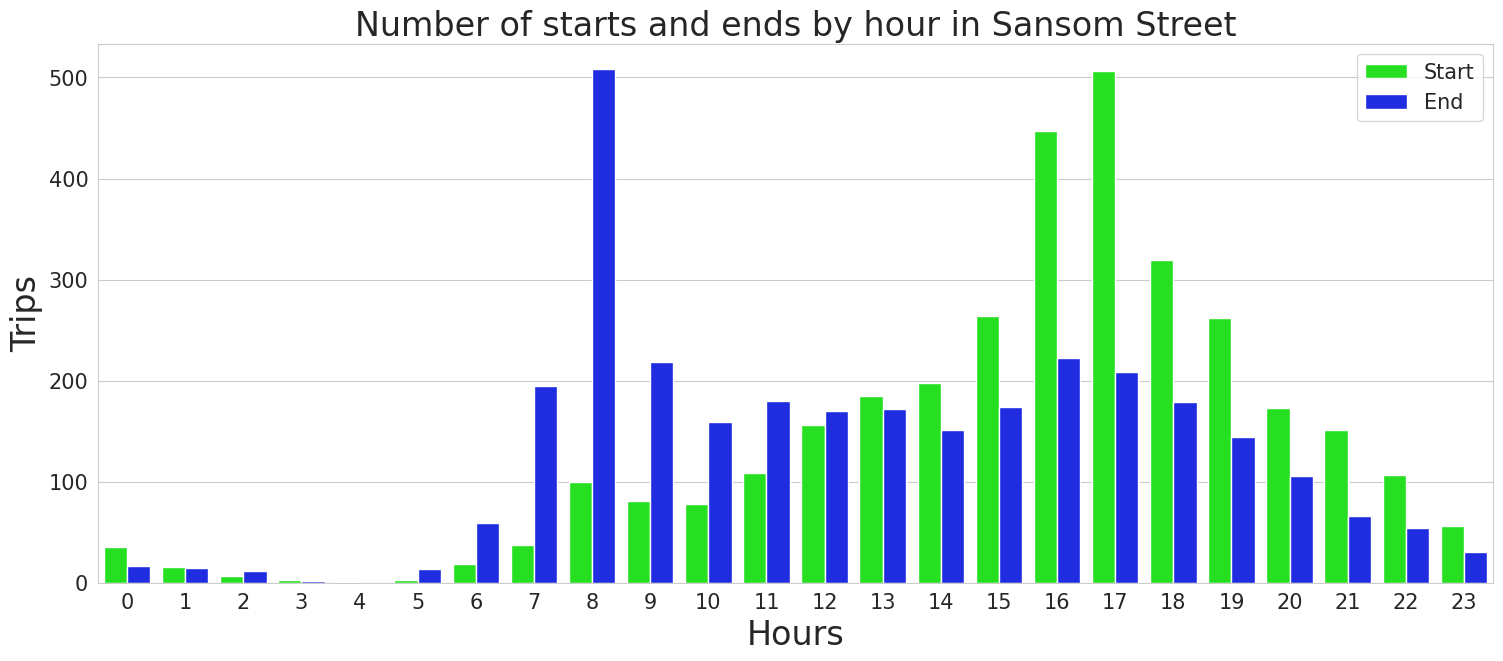

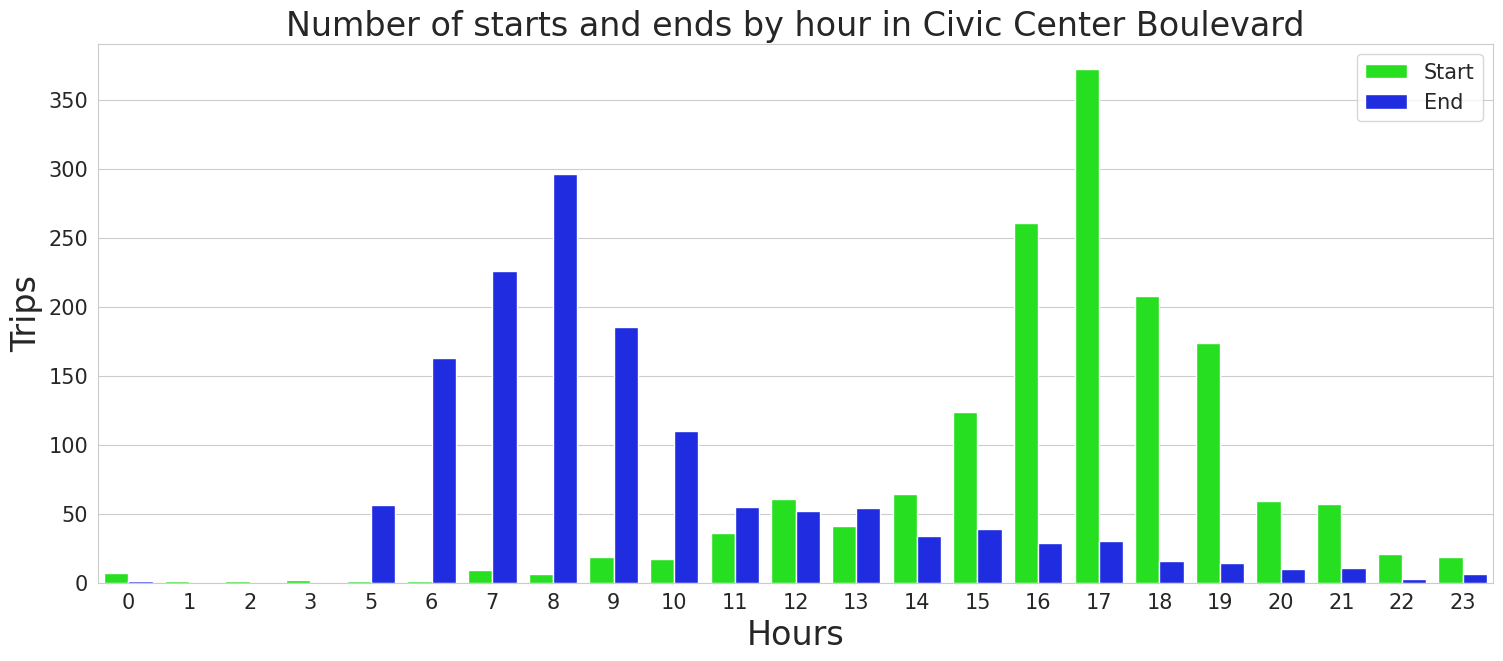

In [117]:
districts = ["Underground Concourse", "Sansom Street", "Civic Center Boulevard"]

for district in districts:
    plot_area_hour_start_end(district)

In [119]:
start_area = df[['Start Area Name', 'hour']].groupby(["Start Area Name", "hour"]).value_counts().reset_index()
start_area.columns = ["Area", "Hour", "Trips"]

end_area = df[['End Area Name', 'hour']].groupby(["End Area Name", "hour"]).value_counts().reset_index()
end_area.columns = ["Area", "Hour", "Trips"]

morning_start_area = start_area[(start_area["Hour"] >= 5) & (start_area["Hour"] <= 10)].groupby("Area").agg({"Trips": "sum"}).reset_index()
morning_end_area = end_area[(end_area["Hour"] >= 5) & (end_area["Hour"] <= 10)].groupby("Area").agg({"Trips": "sum"}).reset_index()
morning_start_area.columns = ["Area", "Starts"]
morning_end_area.columns = ["Area", "Ends"]
morning = pd.merge(morning_start_area, morning_end_area, on='Area')

evening_start_area = start_area[(start_area["Hour"] >= 15) & (start_area["Hour"] <= 19)].groupby("Area").agg({"Trips": "sum"}).reset_index()
evening_end_area = end_area[(end_area["Hour"] >= 15) & (end_area["Hour"] <= 19)].groupby("Area").agg({"Trips": "sum"}).reset_index()
evening_start_area.columns = ["Area", "Starts"]
evening_end_area.columns = ["Area", "Ends"]
evening = pd.merge(evening_start_area, evening_end_area, on='Area')
evening

Area  Starts  Ends
0   33rd Street Sidepath     110   102
1            Arch Street    1687  1318
2      Bainbridge Street    1104  1823
3           Beach Street     115   111
4      Brandywine Street     389   365
..                   ...     ...   ...
67     Washington Avenue     472   837
68        Webster Street     730  1492
69     West Berks Street     353   271
70    West Girard Avenue     497   797
71    West Master Street      43    55

[72 rows x 3 columns]

In [126]:
def draw_starts_number_map(data):
    location_start_map = folium.Map(location=[39.9539, -75.16902], zoom_start=13)
    for area,starts,ends in data:
        area_id = areas_map[area]
        lat = area_geo_position[area_id, 1]
        long = area_geo_position[area_id, 2]
        count = abs(starts-ends)
        color = "#FF0000"
        if starts > ends:
            color = "#008000"

        radius = count / 200
        popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    Count : {}<br>"""
        popup_text = popup_text.format(lat, long, count)
        folium.CircleMarker(location=(lat, long), fill=True, radius=radius, popup=popup_text, color=color).add_to(location_start_map)
    return location_start_map

In [127]:
draw_starts_number_map(morning.values)
# Green - more starts, Red - more ends

In [128]:
draw_starts_number_map(evening.values)